<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-attempt-sticking-grizli-output-into-PostgreSQL-tables" data-toc-modified-id="First-attempt-sticking-grizli-output-into-PostgreSQL-tables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First attempt sticking grizli output into PostgreSQL tables</a></span><ul class="toc-item"><li><span><a href="#postgresql-tables-on-AWS-RDS" data-toc-modified-id="postgresql-tables-on-AWS-RDS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>postgresql tables on AWS RDS</a></span></li><li><span><a href="#Redshift-fit-status-flags-from-the-fits-run-on-Lambda" data-toc-modified-id="Redshift-fit-status-flags-from-the-fits-run-on-Lambda-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Redshift fit status flags from the fits run on Lambda</a></span></li><li><span><a href="#Example-query:-z_grism-vs-z_spec" data-toc-modified-id="Example-query:-z_grism-vs-z_spec-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Example query: z_grism vs z_spec</a></span><ul class="toc-item"><li><span><a href="#Full-table:-HERE" data-toc-modified-id="Full-table:-HERE-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Full table: <a href="https://s3.amazonaws.com/grizli-v1/tables/zspec_delta.html?&amp;status_min=5.5" target="_blank">HERE</a></a></span></li><li><span><a href="#1D-spectra-in-the-database!" data-toc-modified-id="1D-spectra-in-the-database!-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>1D spectra in the database!</a></span></li><li><span><a href="#3D-HST" data-toc-modified-id="3D-HST-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>3D-HST</a></span></li><li><span><a href="#Objects-near-quasars" data-toc-modified-id="Objects-near-quasars-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Objects near quasars</a></span></li><li><span><a href="#Missing-fits" data-toc-modified-id="Missing-fits-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>Missing fits</a></span></li></ul></li></ul></li></ul></div>

# First attempt sticking grizli output into PostgreSQL tables

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML

import pandas as pd
pd.set_option('display.max_colwidth', None)

from grizli import utils, __version__
from grizli.aws import db

try:
    from mastquery import overlaps
except:
    overlaps = None
    
print('Grizli version: ', __version__)
utils.set_warnings()

Grizli version:  1.4.0.dev53


## postgresql tables on AWS RDS

I've started dumping information into `postgresql` tables and the potential seems awesome, even for my hacky database layout.  

**How does one set this up on TAP / ADQL??**

In [4]:
# readonly DB access
config = {'hostname': 'grizli2021.ct1dygxyu3mt.us-east-1.rds.amazonaws.com',
 'username': '***',
 'password': '***',
 'database': '***',
 'port': 5432}

# sqlalchemy engine for postgresql
engine = db.get_db_engine(config=config)
print('Tables: ', engine.table_names())

/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  # Remove the CWD from sys.path while we load stuff.


Tables:  ['mosfire_extractions', 'q_z_tmp', 'mast_products', 'multibeam_tmp', 'spec1d_r30_g800l', 'spitzer_log', 'mosfire_spectra_y', 'spec1d_g800l_wave', 'shifts_log', 'field_observation', 'redshift_fit_quasar_v2', 'redshift_fit_quasar', 'spec1d_r30_g141_wave', 'wcs_log', 'spec1d_g141', 'redshift_fit', 'spec1d_g141_wave', 'photometry_irac', 'exposure_log', 'mosaic_tiles', 'spec1d_g102', 'mosfire_datemask', 'exposure_files', 'mosaic_tiles_exposures', 'log_tmp', 'assoc_table', 'spatial_ref_sys', 'dash_grism_alignment', 'spec1d_r30_g102_v2', 'multibeam', 'beam_geometry_v2', 'spec1d_g141_v2', 'spec1d_g800l', 'spec1d_r30_g141', 'spec1d_r30_g102', 'spec1d_g102_v2', 'spec1d_r30_g102_wave', 'beam_geometry', 'redshift_fit_v2', 'spec1d_r30_g141_v2', 'stellar_fit_v2', 'observation', 'mosfire_spectra_h', 'stellar_fit', 'mosfire_exposures', 'mosfire_spectra_k', 'spitzer_aors', 'mosfire_phot_matches', 'mosfire_spectra_j', 'survey_fields', 'spec1d_r30_g141_v2_wave', 'spec1d_r30_g102_v2_wave', 'spec1

## Redshift fit status flags from the fits run on Lambda

`redshift_fit.status`:

  **`3`** - The object should have an extracted `beams.fits` file in the S3 filesystem

  **`5`** - extractions and redshift fits that timed out in the 15 minute Lambda limit, 
            e.g., some deep pointings or unconstrained fits that find many peaks on the second pass

  **`6`** : completed redshift fits with full information stored in the `redshift_fit` table.


In [5]:
print(db.FLAGS)

{'init_lambda': 1, 'start_beams': 2, 'done_beams': 3, 'no_run_fit': 4, 'start_redshift_fit': 5, 'fit_complete': 6}


In [6]:
for table in ['charge_fields', 'photometry_apcorr', 'redshift_fit']:
    photom = db.from_sql('select * from {0} where false;'.format(table), engine)
    cols = list(photom.colnames)
    count = db.from_sql('select count(*) as n from {0};'.format(table), engine)
    
    print('###  Table `{0}`: {1} rows x {2} columns   ###\n' .format(table, 
                                                    count['n'][0], len(photom.colnames)))
    
    r, c = 6, 10
    for i in range(c):
        print('   '+', '.join(['{0:10}'.format(ci) for ci in cols[i*r:(i+1)*r]]))
    print('    ...\n')      

###  Table `charge_fields`: 4073 rows x 376 columns   ###

   qtime     , boxra     , boxdec    , boxrad    , obsquery  , field_root
   field_ra  , field_dec , mw_ebv    , folap     , min_area  , buffer    
   field_xmin, field_xmax, field_ymin, field_ymax, boxquery  , nassoc    
   ecllat    , ecllon    , gallat    , gallon    , nfilt     , filters   
   target    , target_classification, proposal_id, proposal_pi, ng102     , areag102  
   texpg102  , tperg102  , pag102    , ng141     , areag141  , texpg141  
   tperg141  , pag141    , ng800l    , areag800l , texpg800l , tperg800l 
   pag800l   , ng280     , areag280  , texpg280  , tperg280  , pag280    
   mast      , skip      , has_wfc3ir, comment   , gaia5     , t_acs_wfc_clear1l_f814w
   wh_acs_wfc_clear1l_f814w, a_acs_wfc_clear1l_f814w, t_acs_wfc_f435w, wh_acs_wfc_f435w, a_acs_wfc_f435w, t_acs_wfc_f475w
    ...

###  Table `photometry_apcorr`: 2819080 rows x 1479 columns   ###

   thresh    , npix      , tnpix     , image_xmin, 

## Example query: z_grism vs z_spec

Here z_specs are taken from a large variety of literature sources.
I've taken separate tables and matched them into the `photometry_apcorr` database, but 
this would better be done with a separate z_spec table in the database.

The `make_html_table` function below automatically does a join on `redshift_fit` and `photometry_apcorr` based on the object `root` + `id` combinations.

If you don't set `get_sql=True`, it makes a sortable HTML table like the link below sends it to the S3 target specified in `sync`.

### Full table: [HERE](https://s3.amazonaws.com/grizli-v1/tables/zspec_delta.html?&status_min=5.5)

In [9]:
db.make_html_table?

In [10]:
extra = "AND status > 4 AND z_spec > 0 AND z_spec_qual = 1" # AND z_spec_src NOT LIKE '%%Caminha%%'"
extra += "AND (t_g102 > 10 OR t_g141 > 10)"
#extra += "AND (t_g800l > 0)"

SQLtxt = db.make_html_table(engine=engine, 
                   columns=['root','status','id','ra','dec','mag_auto','flux_radius',
                            't_g800l','t_g102','t_g141',
                            'z_spec','z_map','z_spec_src','bic_diff','chinu','log_pdf_max', 
                            'zwidth1/(1+z_map) as zw1','(z_map-z_spec)/(1+z_spec) as dz','q_z'], 
                   where=extra, 
                   fit_table='redshift_fit', 
                   table_root='zspec_delta', sync='s3://grizli-v1/tables/', 
                   png_ext=['R30', 'stack','full','line'], get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# Below is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
res = db.from_sql(SQLtxt, engine)
print('N:',len(res))

SELECT root,status,id,ra,dec,mag_auto,flux_radius,t_g800l,t_g102,t_g141,z_spec,z_map,z_spec_src,bic_diff,chinu,log_pdf_max,zwidth1/(1+z_map) as zw1,(z_map-z_spec)/(1+z_spec) as dz,q_z 
    FROM photometry_apcorr, redshift_fit 
    WHERE phot_root = p_root AND id = p_id AND status > 4 AND z_spec > 0 AND z_spec_qual = 1AND (t_g102 > 10 OR t_g141 > 10);
N: 12393


Color by q_z


/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


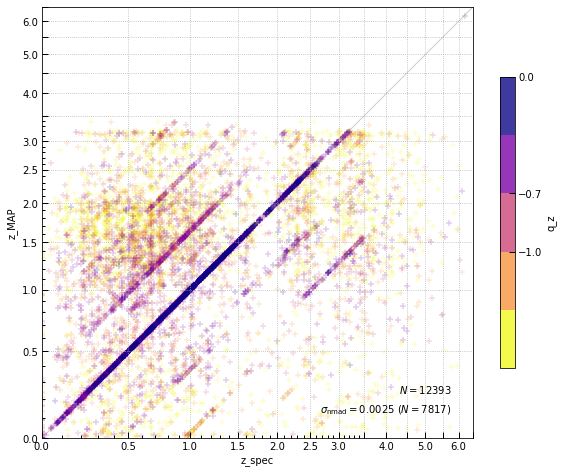

In [11]:
# z_grism vs z_spec
from matplotlib.ticker import FixedLocator, AutoLocator, MaxNLocator
import matplotlib as mpl

# Pseudolog in log(1+z)
xti = xt = np.arange(0,6.6,0.5)
xti = list(xti)
for i in range(len(xti)):
    if (xti[i] > 3) & (xti[i] != int(xti[i])):
        xti[i] = ''

loc = np.arange(0, 3.6, 0.1)

fig = plt.figure(figsize=[8,7])
ax = fig.add_subplot(111)

if False:
    print('Color by zwidth')
    cby = 'zw'
    kwargs = {'marker':'.', 'vmin':-3.5, 'vmax': -0.5, 'cmap': 'plasma'}
    c = np.log10(res['zw1'])
    so = np.argsort(c)[::-1]
else:
    print('Color by q_z')
    cby = 'q_z'
    cmap = plt.cm.plasma_r
    bounds = [-2, -1.5, -1, -0.7, -0.3, 0]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    kwargs = {'marker':'+', 'vmin':-1.5, 'vmax': 0, 'cmap': cmap, 'norm':norm}
    c = res['q_z']
    so = np.argsort(c)
    
ax.scatter(np.log(1+res['z_spec'][so]), np.log(1+res['z_map'][so]), alpha=0.2, 
           c=c[so], **kwargs)

# dummy replot for darker colorbar
sc = ax.scatter(np.log([1]), np.log([1]), alpha=0.8, c=[0], **kwargs)
cb = plt.colorbar(sc, shrink=0.6)

if cby == 'zw':
    cb.set_label(r'$(z_{84}-z_{16})/(1+z_{50})$')
    cb.set_ticks([-3,-2,-1])
    cb.set_ticklabels([0.001, 0.01, 0.1])
elif cby == 'q_z':
    cb.set_label(r'q_z')
    cb.set_ticks([-1, -0.7, 0])
    #cb.set_ticklabels([0.001, 0.01, 0.1])
    
xts = ax.set_xticks(np.log(1+xt))
xtl = ax.set_xticklabels(xti)
xts = ax.set_yticks(np.log(1+xt))
xtl = ax.set_yticklabels(xti)

ax.set_xlim(0, np.log(1+6.5))
ax.set_ylim(0, np.log(1+6.5))

ax.xaxis.set_minor_locator(FixedLocator(np.log(1+loc)))                                                                                                                                          
ax.yaxis.set_minor_locator(FixedLocator(np.log(1+loc)))      

ax.set_xlabel('z_spec')
ax.set_ylabel('z_MAP')

ax.set_aspect(1)
ax.grid()
ax.text(0.95, 0.1, r'$N={0}$'.format(len(res)), ha='right', va='bottom', 
        transform=ax.transAxes)

dz = (res['z_map'] - res['z_spec'])/(1+res['z_spec'])
#sel = (res['z_spec'] > 0) & (np.abs(dz) < 0.1)
#sel = (res['z_spec'] > 0) & (res['zw1'] < 0.05)
sel = (res['z_spec'] > 0) & (res['q_z'] > -1.0)

ax.text(0.95, 0.05, r'$\sigma_\mathrm{{{{nmad}}}}={0:.4f}$ ($N={1}$)'.format(utils.nmad(dz[sel]), sel.sum()), 
        ha='right', va='bottom', transform=ax.transAxes)

ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', 
        alpha=0.2, linewidth=1, zorder=-10)

fig.tight_layout(pad=0.1)

In [12]:
# Count redshift sources
if 0:
    print('z_spec references, in both imaging and spectroscopy')
    SQL = """
    SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM photometry_apcorr 
        WHERE z_spec_qual = 1 GROUP BY z_spec_src) foo ORDER BY n DESC;
    """
else:
    # overlap with spectroscopy
    print('z_spec references, overlap with spectroscopy')
    SQL = """
    SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM redshift_fit, photometry_apcorr 
        WHERE root = p_root AND id = p_id AND z_spec_qual = 1 GROUP BY z_spec_src) foo ORDER BY n DESC;
    """
    
counts = db.from_sql(SQL, engine)
print('N_src={0}, N_tot={1}\n'.format(len(counts), counts['n'].sum()))

nr = 40
msg = '{0:>26}  {1:4}   {2:>26}  {3:4}'
print(msg.format('z_spec_src','n','z_spec_src','n'))
print('='*80)
for i in range(nr):
    print(msg.format(counts['z_spec_src'][i], counts['n'][i], 
                     counts['z_spec_src'][i+nr], counts['n'][i+nr]))
    

z_spec references, overlap with spectroscopy
N_src=109, N_tot=15236

                z_spec_src  n                      z_spec_src  n   
                 DEEP2 DR4  1697                    ESO v3 15    51
           Cowie 2004 TKRS  1286                    ESO v3 16    45
         DEEP3 Cooper 2011  1137             GAMA SpecObj/v27    44
          ACES Cooper 2012  1118                 Rudnick 2017    44
              MOSDEF v2018   995              Eisenhardt 2008    39
                    sparcs   642                   Stern 2010    35
    Urrutia 2018 MUSE-Wide   625                   Casey 2012    34
                 ESO v3 14   568               sdss-dr15-STAR    32
      Inami 2017 MUSE-Deep   557                Carrasco 2017    31
               Rosani 2020   514                    deep2-dr4    29
            Liu 2008 comp.   420                     Ono 2018    28
  KMOS3D v3 Wisnioski 2019   363               Veron 2006 QSO    24
               Balogh 2014   358               

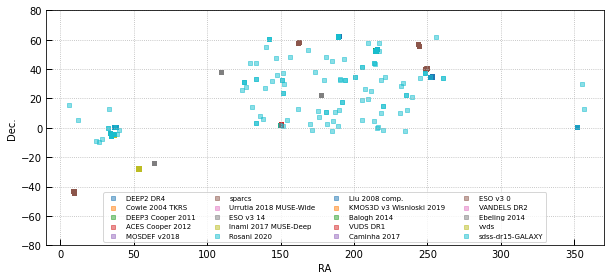

In [14]:
# Show where the sources are on the sky
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

for src in counts['z_spec_src'][0:20]:
    sub = res['z_spec_src'] == src
    ax.scatter(res['ra'][sub], res['dec'][sub], marker='s', s=20, 
               label=src, alpha=0.5)

ax.set_aspect(1)
ax.set_xlim(-10, 370); ax.set_ylim(-80, 80)
ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
ax.grid()
ax.legend(loc='lower center', fontsize=7, ncol=4)

In [15]:
# Individual object: high-z quasar
where = "AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1 AND z_spec_src = 'Wang 2016 high-z QSO'"

SQLtxt = db.make_html_table(engine=engine, 
                                columns=['status','root','id','ra','dec','mag_auto','flux_radius',
                                         'z_spec','z_map','z_spec_src'], 
                                fit_table='redshift_fit', 
                                where=where,  get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# `from_sql` is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
highz = db.from_sql(SQLtxt, engine)

SELECT status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src 
    FROM photometry_apcorr, redshift_fit 
    WHERE phot_root = p_root AND id = p_id AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1 AND z_spec_src = 'Wang 2016 high-z QSO';


In [16]:
highz

status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src
int64,str12,int64,float64,float64,float64,float64,float64,float64,str20
6,j142952p5447,719,217.46740,54.78823,20.55,1.2,6.210,6.172,Wang 2016 high-z QSO


In [17]:
HTML(db.render_for_notebook(highz['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full']))

/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/grizli/aws/db.py:1870: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full
0,j142952p5447,719,217.467397,54.788229,20.549747,6.21,6.17207,,


### 1D spectra in the database!

Every object in the `redshift_fit` table has 1D spectra stored in additional tables `spec1d_g800l`, `spec1d_g102`, and `spec1d_g141`.

The columns of those tables are like:

  - `_flux`: Extracted flux
  - `_err`: Uncertainty
  - `_flat`: Model spectrum for a flat spectrum with flux 1 erg/s/cm2/A used for flux calibration
  - `_contam`: Contamination
  - `_cont`: Best-fit template, continuum only
  - `_line`: Best-fit templates, line **plus** continuum
 
The units of the spectra are the native detector `electrons per second`.  To convert to cgs flux densities, divide by the `_flat` column.

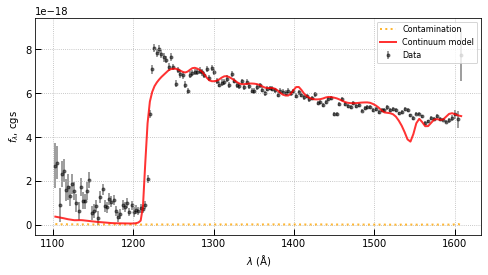

In [18]:
# 1D spectra
tablename = 'spec1d_g102'

SQL = """SELECT root, id, z_map, sp.* from redshift_fit, {1} as sp 
          WHERE root = '{0}' AND id = {2} AND {1}_root = root AND {1}_id = id""".format(highz['root'][0], 
                                                                                        tablename, highz['id'][0])
resp = db.from_sql(SQL, engine)

# Wavelengths stored in a separate table
wave = db.from_sql("SELECT * from {0}_wave".format(tablename), engine)[tablename+'_wave']

# Plot the spectra
data = {}
for c in ['flux','err','flat','contam','line','cont']:
    data[c] = np.array(resp['{0}_{1}'.format(tablename, c)][0])

rest_wave = wave / (1+resp['z_map'][0])

fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(111)

er = ax.errorbar(rest_wave, data['flux']/data['flat'], data['err']/data['flat'], 
             marker='.', color='k', linestyle='None', alpha=0.5, label='Data', zorder=-1)

pl = ax.plot(rest_wave, data['contam']/data['flat'], color='orange', linestyle=':', 
              alpha=0.8, linewidth=2, label = 'Contamination')

pl = ax.plot(rest_wave, data['cont']/data['flat'], color='r', 
              alpha=0.8, linewidth=2, label = 'Continuum model')

ax.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
ax.set_ylabel(r'$f_\lambda$, cgs')
ax.legend(loc='upper right', fontsize=8)
ax.grid()

In [19]:
# Quasars
sel = (res['z_spec_src'] == 'sdss-dr15-QSO') | (res['z_spec_src'] == 'Veron 2006 QSO')
sel |= (res['z_spec_src'] == 'KODIAQ')
sel |= np.array(['lqac' in src for src in res['z_spec_src']])
sel |= np.array(['QSO' in src for src in res['z_spec_src']])

print('{0} Quasars from:\n    {1}'.format(sel.sum(), '\n    '.join(np.unique(res['z_spec_src'][sel]))))


96 Quasars from:
    KODIAQ
    QSO B0117+2118 Simbad
    Veron 2006 QSO
    Wang 2016 high-z QSO
    lqac_032-000_098
    lqac_148+035_025
    lqac_172+013_045
    lqac_221+029_005
    sdss-dr15-QSO


In [20]:
# Rigby et al. "MegaSaura" Arc
sel = (res['z_spec_src'] == 'Rigby 2018')
print('\n{0} Megasaura arc images'.format(sel.sum()))

HTML(db.render_for_notebook(res[sel]['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full','line']))


5 Megasaura arc images


/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/grizli/aws/db.py:1870: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full,line
0,j032728m1326,1475,51.867475,-13.436768,20.096246,1.703884,1.70493,,,
1,j032728m1326,815,51.863205,-13.448375,21.165216,1.703070,1.70306,,,
2,j032728m1326,1467,51.860756,-13.437508,20.120374,1.703850,1.70065,,,
3,j032728m1326,1477,51.865732,-13.435495,20.994835,1.703600,1.70429,,,
4,j032728m1326,1476,51.866474,-13.435854,20.665002,1.703400,1.70635,,,


### 3D-HST

Spectra in EGS, COSMOS, and UDS have been processed but those fields don't have a full `z_spec` catalog yet.  The field names are a bit different than the `jHHMMSSxDDMMSS` format for the other archival fields.

In [21]:
# G102 + G141
query = '%%-grism%%'

# G800L
#query = '%%-g800l%%'

SQLtxt = """
SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr NATURAL JOIN redshift_fit
WHERE status > 4 AND root LIKE '{0}';
""".format(query)

print(SQLtxt)
tab = db.from_sql(SQLtxt, engine)

fields = np.unique(tab['root'])

print('N total: {0} \nN fields: {1}\n'.format(len(tab), len(fields)))

print('\n'.join(fields))


SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr NATURAL JOIN redshift_fit
WHERE status > 4 AND root LIKE '%%-grism%%';

N total: 92756 
N fields: 5

cos-grism-j100012p0210
egs-grism-j141956p5255
gdn-grism-j123656p6215
gds-grism-j033236m2748
uds-grism-j021732m0512


In [22]:
# mag limit
mag_lim = 24
msel = tab['mag_auto'] < mag_lim

# Full photometric catalog
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto 
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < {1} ORDER BY mag_auto;
"""

extra = {}
for field in fields:
    extra[field] = db.from_sql(SQLphot.format(field.replace('-g800l','-grism'), mag_lim), engine)
    print(field, len(extra[field]))

cos-grism-j100012p0210 18215
egs-grism-j141956p5255 12252
gdn-grism-j123656p6215 7531
gds-grism-j033236m2748 11937
uds-grism-j021732m0512 8563


In [23]:
ct = 'g141'

if ct == 'g800l':
    print('Color on G800l exposure time')
    c = (np.log10(tab['t_g800l']),3,5)
elif ct == 'g141':
    print('Color on G141 exposure time')
    c = (np.log10(tab['t_g141']),3,5)
elif ct == 'g102':
    print('Color on G102 exposure time')
    c = (np.log10(tab['t_g102']),3,5)
else:
    print('Color on redshift fit status (5=timeout, 6=complete)')
    c = (tab['status'],4.5,6.2)

Color on G141 exposure time


field: cos-grism-j100012p0210, n_grism, (< 24) = 17122 (5842), n_full = 18215


/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/mastquery/overlaps.py:1115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.to_string(u.hourangle, pad=True, fields=2+((xmaj < 60)), precision=0, format=format) for i, t in enumerate(xcoo)])
/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/mastquery/overlaps.py:1116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([t.to_string(u.deg, pad=True, fields=2+(ymaj < 1), format=format) for t in ycoo])


field: egs-grism-j141956p5255, n_grism, (< 24) = 22775 (7422), n_full = 12252
field: gdn-grism-j123656p6215, n_grism, (< 24) = 17482 (5570), n_full = 7531
field: gds-grism-j033236m2748, n_grism, (< 24) = 19509 (6101), n_full = 11937
field: uds-grism-j021732m0512, n_grism, (< 24) = 15868 (4689), n_full = 8563


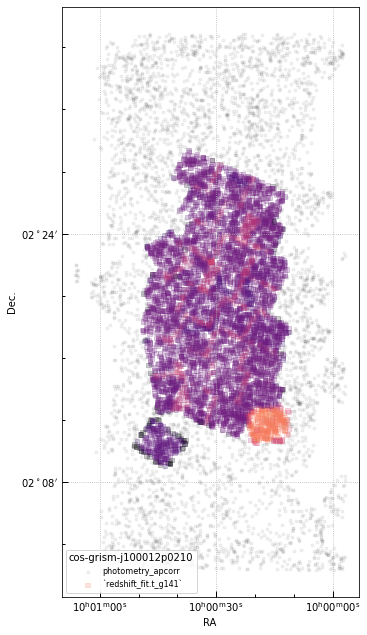

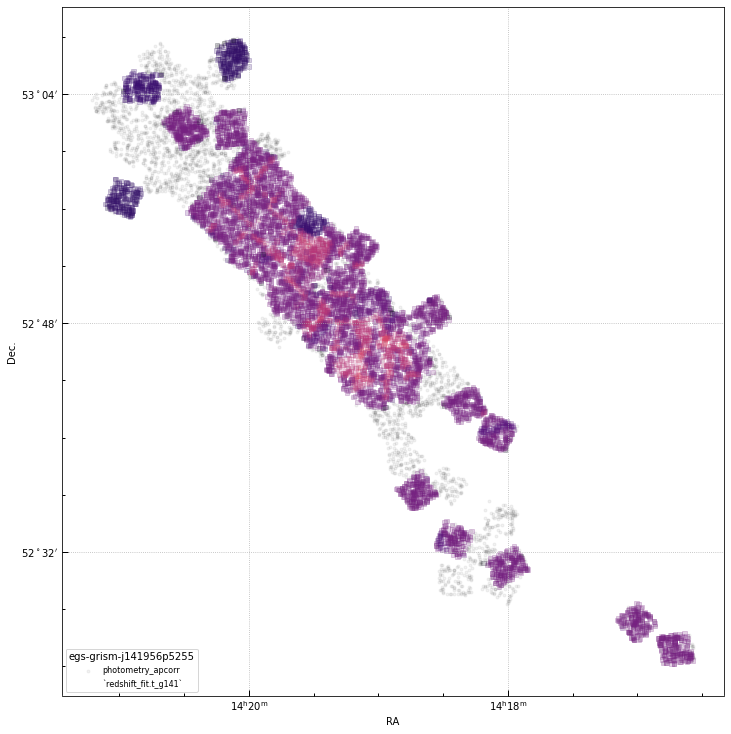

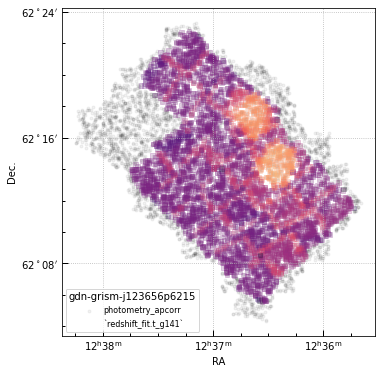

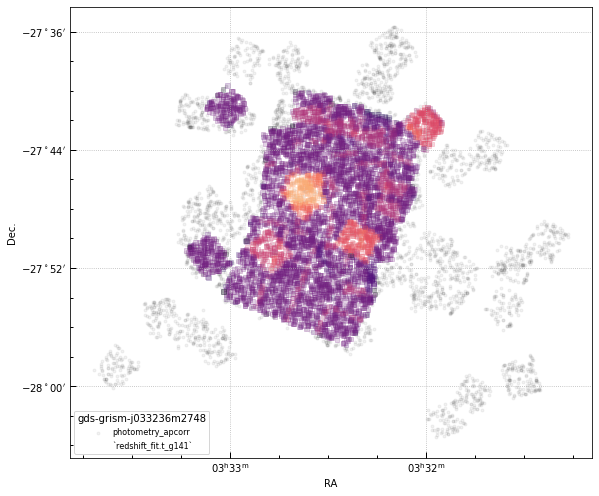

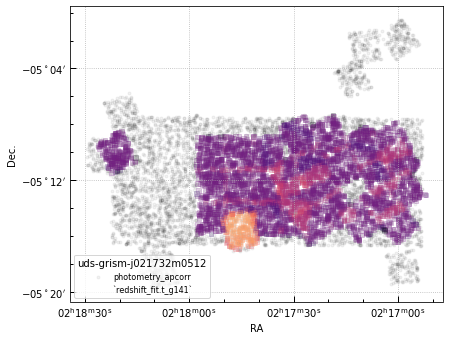

In [24]:
# Show the field layouts

for field in fields:
    fsel = (tab['root'] == field)
    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]
    
    # All sources from parent photometry database
    ex = extra[field]
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    msg = 'field: {0}, n_grism, (< {3:.0f}) = {1:4} ({2:4}), n_full = {4:4}'
    print(msg.format(field, fsel.sum(), (fsel & msel).sum(), mag_lim, len(ex)))
    
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(5*(np.maximum(dx, dy)/20), 5, 10)

    fig = plt.figure(figsize=[s,s])
    ax = fig.add_subplot(111)
    
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
               alpha=0.05, zorder=-1, label='photometry_apcorr')

    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='s', s=20, vmin=c[1], vmax=c[2], cmap='magma', 
               label='`redshift_fit.{0}`'.format(c[0].name))
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    leg = ax.legend(title=field, loc='lower left', fontsize=8)
    
#     ax.text(0.03, 0.03, field, ha='left', va='bottom', 
#             transform=ax.transAxes, fontsize=9, 
#             bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})
    
    ax.grid()

### Objects near quasars

Look at some quasar fields selected to be rich absorbers but that also often have excess sources around the quasar itself.

In [25]:
# Get field information from the charge database
pi_names = ['Bielby']

#pi_names = ['Lotz'] # GLASS on FFs

field_query = 'AND (' + 'OR '.join(["proposal_pi LIKE '%%{0}%%'".format(pi) for pi in pi_names]) + ')'

## other test query
# field_query = "AND (field_t_g141 > 4000 AND field_t_g102 > 4000 AND field_t_g141 < 8000"
# field_query += "AND comment = 'WSP' AND gaia5 < 10)"

SQLtxt = """
SELECT root,target,proposal_pi,count(root) as n
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE phot_root = p_root AND id = p_id AND field_root = p_root AND status > 4 {field_query}
GROUP BY root,target,proposal_pi;
""".format(field_query=field_query)
print(SQLtxt)

parent = db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))
parent


SELECT root,target,proposal_pi,count(root) as n
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE phot_root = p_root AND id = p_id AND field_root = p_root AND status > 4 AND (proposal_pi LIKE '%%Bielby%%')
GROUP BY root,target,proposal_pi;

N total: 12 
N fields: 12


root,target,proposal_pi,n
str12,str26,str26,int64
j012016p2134,PG0117+213,Bielby,561
j023508m0402,HB890232-042 PHL1377,Bielby Lehner,566
j051708m4411,HE0515-4414,Bielby,509
j075056p4252,2MASSIJ0750546+425219,Bielby,422
j081332p2545,HS0810+2554 QSO-B0810+2554,Bielby Kochanek Nierenberg,526
j101956p2744,QSO-J1019+2745,Bielby,449
j112444m1705,2MASSIJ1124428-170517,Bielby,487
j113008m1449,QSO-J1130-1449,Bielby,473
j143748m0147,LBQS-1435-0134,Bielby Mulchaey,623


In [26]:
# Select histogram on grism redshifts, otherwise try to use z_spec
GRISM_HISTOGRAM = False

j012016p2134 Ntot=292 Nmag=253 Nphot=321 n(z_spec)=2
j023508m0402 Ntot=211 Nmag=165 Nphot=361 n(z_spec)=6
j051708m4411 Ntot=276 Nmag=232 Nphot=272 n(z_spec)=1
j075056p4252 Ntot=188 Nmag=166 Nphot=226 n(z_spec)=3
j081332p2545 Ntot=267 Nmag=239 Nphot=328 n(z_spec)=3
j101956p2744 Ntot=226 Nmag=201 Nphot=243 n(z_spec)=1
j112444m1705 Ntot=185 Nmag=173 Nphot=305 n(z_spec)=1
j113008m1449 Ntot=250 Nmag=229 Nphot=276 n(z_spec)=1
j143748m0147 Ntot=273 Nmag=238 Nphot=447 n(z_spec)=3
j152424p0958 Ntot=257 Nmag=219 Nphot=412 n(z_spec)=1


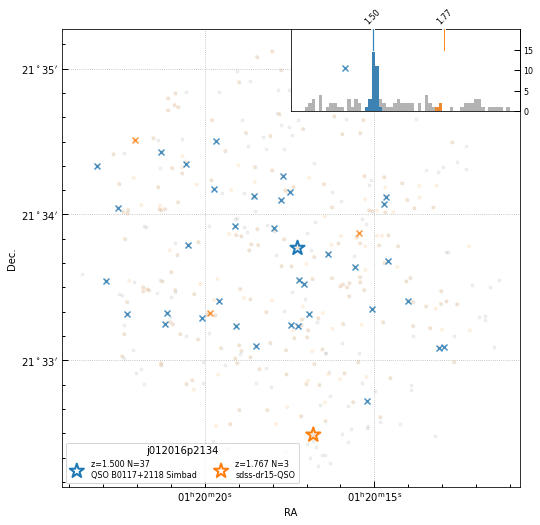

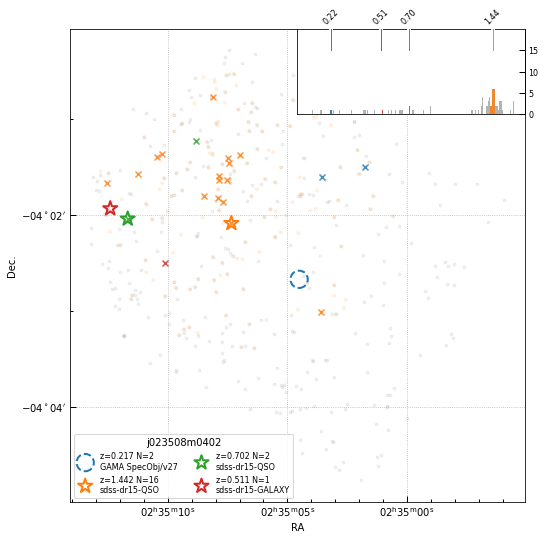

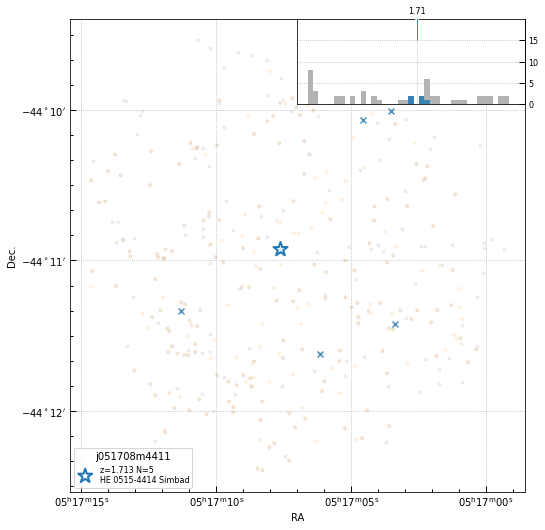

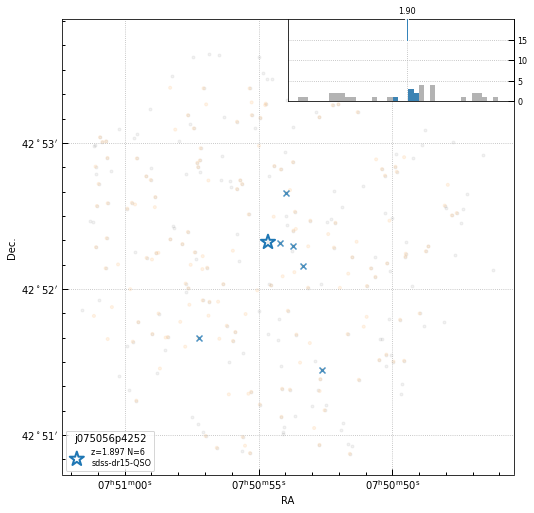

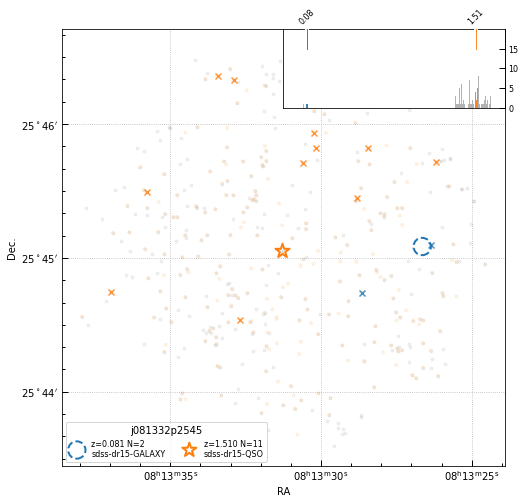

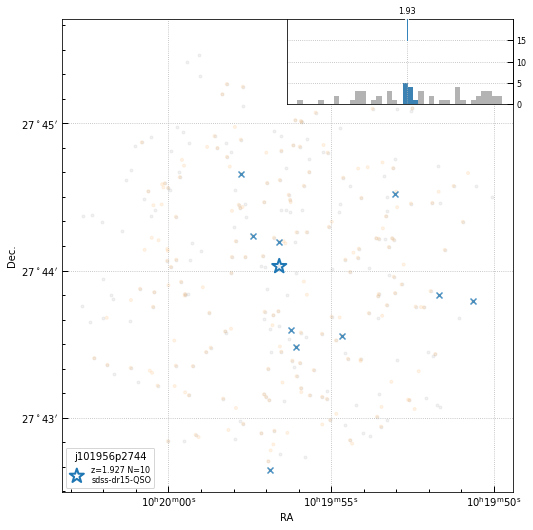

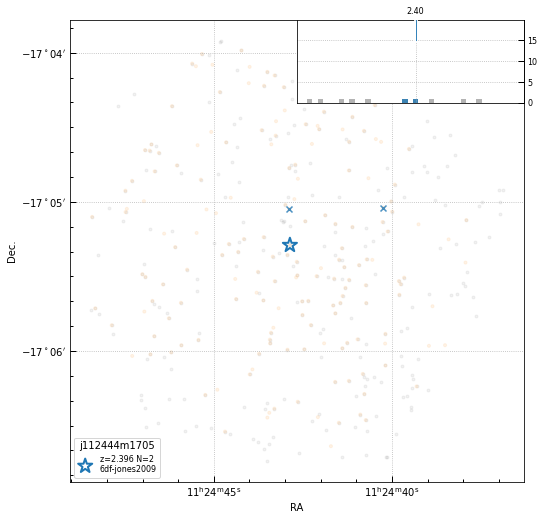

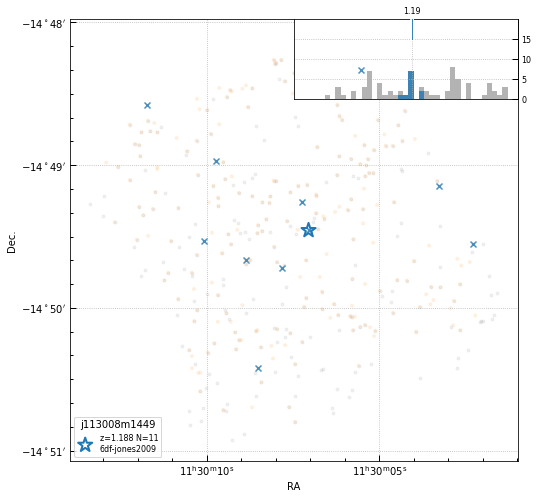

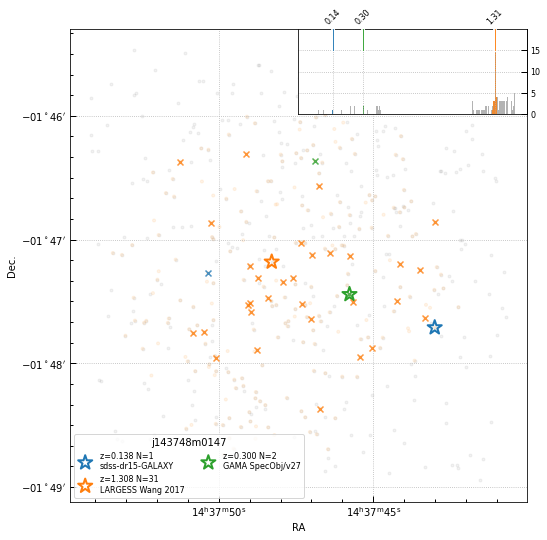

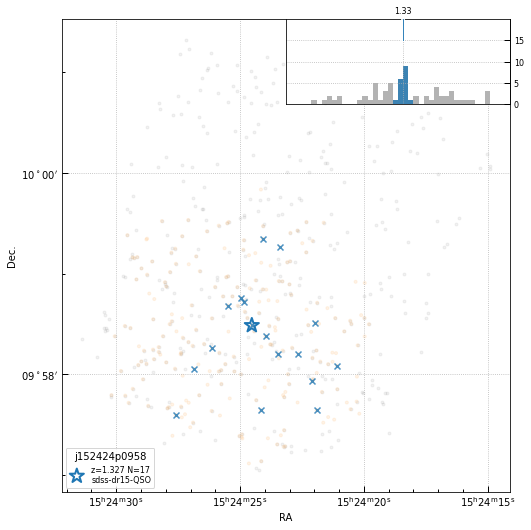

In [27]:
########## Make field layout plots with optional histograms
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto, z_spec, z_spec_src
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < 24 ORDER BY mag_auto;
"""

SQLroot = """
SELECT status,phot_root,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id AND status > 4 AND (root = '{0}') AND q_z > -1.0;"""

fields = np.unique(parent['root'])

# bins for histograms
bins = utils.log_zgrid([0.01, 3.5], 0.005)

# Coarse binning for maxima
spbins = utils.log_zgrid([0.01, 3.5], 0.03)

URL = 'https://s3.amazonaws.com/grizli-v1/Pipeline/{0}/Extractions/{0}.html?&z_map_min={1:.04f}&z_map_max={2:.04f}'
URL += '&bic_diff_min=10&chinu_max=2'

links = []
for field in fields[:10]:
    
    tab = db.from_sql(SQLroot.format(field), engine)

    msel = tab['mag_auto'] < 25
    #qso = tab['z_spec_src'].filled('---') == 'sdss-dr15-QSO'
    try:
        qso = (tab['z_spec_qual'].filled(0) == 1) #== 'sdss-dr15-QSO'
        qso &= ~utils.column_string_operation(tab['z_spec_src'].filled('---'), 'erb', 'startswith')
    except:
        qso = (tab['z_spec_qual'] == 1) #== 'sdss-dr15-QSO'
        qso &= ~utils.column_string_operation(tab['z_spec_src'], 'erb', 'startswith')
        
    # Color by status
    c = (tab['status'], 4.5, 6.2)
    # Color by grism exposure time
    #c = (np.log10(tab['t_g800l'].filled(1) + tab['t_g141'].filled(1) + tab['t_g102'].filled(1)), 3, 5)
    
    fsel = (tab['root'] == field)
    fq = fsel & qso

    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]

    # All sources from parent photometry database
    ex = db.from_sql(SQLphot.format(tab['phot_root'][0]), engine)
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    # Figure size
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(8*(np.maximum(dx, dy)/20), 7, 14)
    fig = plt.figure(figsize=[s,s])
    
    ax = fig.add_subplot(111)
    
    # All sources
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
           alpha=0.05, zorder=-1, label=None)
    
    # grism sources
    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='.', vmin=c[1], vmax=c[2], cmap='magma', label=None)
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    #overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')
    
    # Quality redshifts
    qual = (f_i['bic_diff'] > 10) | (f_i['zw1'] < 0.02)
    
    # Show 4 redshift peaks
    max_npeak = 3
    
    d1, d2 = 0.5, 0.18
    ax2 = ax.inset_axes((1-d1, 1-d2, d1, d2))
    xt = []

    # Spectroscopic redshifts from parent catalog
    nmin = 1
    zcol = 'z_spec'
    zhist = ex['ra', 'dec', 'z_spec', 'z_spec_src'][ex['z_spec'] > 0]

    if GRISM_HISTOGRAM | (len(zhist) == 0):
        # Grism objects
        fq = fsel & ((tab['bic_diff'] > 10) | (tab['zw1'] < 0.02))
        nmin = 6
        zcol = 'z_map'
        zhist = tab[fq]['ra', 'dec', zcol]


    print('{0} Ntot={1} Nmag={2} Nphot={3} n({4})={5}'.format(field, fsel.sum(), (fsel & msel).sum(),
                              len(ex), zcol, len(zhist)))

    yh, xh = np.histogram(zhist[zcol], bins=spbins)
    bso = np.argsort(yh)[::-1]

    for i, ib in enumerate(bso):
        if (yh[ib] < nmin) | (i > max_npeak):
            break

        ii = (zhist[zcol] >= xh[ib]) & (zhist[zcol] < xh[ib+1])
        zsp = zhist[zcol][ii].mean()

        if zcol == 'z_spec':
            zsrc = '\n'+','.join(list(np.unique(zhist['z_spec_src'][ii])))
        else:
            zsrc = '\nself(grism)'

        plw = ax2.plot([np.log(1+zsp)]*2, [15, 20], color='w', linewidth=4, alpha=0.9, zorder=8)
        pl = ax2.plot([np.log(1+zsp)]*2, [15, 20], linewidth=1, alpha=0.9, zorder=10)
        color_i = pl[0].get_color()

        b_i = np.abs((bins-zsp)/(1+zsp)) < 0.1
        ax2.hist(np.log(1+f_i['z_map'][qual]), bins=np.log(1+bins[b_i]), color='0.7', zorder=-5)
        xt.append(zsp)

        # Plot positions and histogram of objects near the z_spec (QSO) objects
        near = qual & (np.abs((f_i['z_map']-zsp)/(1+zsp)) < 0.01)

        ax2.hist(np.log(1+f_i['z_map'][near]), bins=np.log(1+bins[b_i]), color=color_i, alpha=0.8)

        label = 'z={0:.3f} N={1}{2}'.format(zsp, near.sum(), zsrc)

        dzi = 0.01*(1+zsp)
        URLi = URL.format(field, zsp-dzi, zsp+dzi)
        links.append(HTML('<a href={0}>{1} / {2}</a>'.format(URLi, field, label)))

        if (zcol == 'z_spec') & (ii.sum() == 1):
            ax.scatter(zhist['ra'][ii][:2], zhist['dec'][ii][:2], 
                   edgecolor=color_i, facecolor='None', alpha=1, 
                   s=220, marker='*', zorder=100, linewidth=2,
                   label=label)
        else:
            ax.scatter(zhist['ra'][ii].mean(), zhist['dec'][ii].mean(), 
                   edgecolor=color_i, facecolor='None', alpha=1, 
                   s=300, marker='o', zorder=100, linewidth=2, linestyle='--',
                   label=label)

        ax.scatter(f_i['ra'][near], f_i['dec'][near], marker='x', 
                   color=color_i, alpha=0.8, zorder=1000,
                   label=None)
            
        ax2.set_xticks(np.log(1+np.array(xt))); 
        ax2.set_xticklabels(['{0:.2f}'.format(xti) for xti in xt], rotation=45*(len(xt) > 1))
        ax2.set_ylim(0,20); ax2.set_yticks([0,5,10,15])
        ax2.grid()
        ax2.tick_params(labelsize=8)
        
        ax2.xaxis.set_ticks_position('top')
        ax2.yaxis.set_ticks_position('right')

        ax.legend(loc='lower left', fontsize=8, title=field, ncol=1+(ib > 2)*1)
    else:
        ax.text(0.03, 0.03, field, ha='left', va='bottom', 
            transform=ax.transAxes, fontsize=9, 
            bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    ax.grid()

# Show URLS
display(*links)

In [28]:
# Fields around SDSS QSOs

# Quasars
# sdss-dr15-QSO
SQLtxt = """
SELECT DISTINCT root
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id 
      AND (z_spec_src = 'sdss-dr15-QSO' OR z_spec_src = 'LBQS' OR z_spec_src = 'KODIAQ') 
      AND status > 4 AND root LIKE 'j%%';
"""
print(SQLtxt)

parent = db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))


SELECT DISTINCT root
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id 
      AND (z_spec_src = 'sdss-dr15-QSO' OR z_spec_src = 'LBQS' OR z_spec_src = 'KODIAQ') 
      AND status > 4 AND root LIKE 'j%%';

N total: 56 
N fields: 56


### Missing fits

There are still some objects with extracted spectra but without entries in the `redshift_fit` table.  These are most often for deep fields where the redshift fit exceded the 15-minute limit on AWS lambda.

In [29]:
SQLtxt = """
SELECT * FROM (SELECT root,target,field_t_g800l,field_t_g141,proposal_pi,count(root) as n
    FROM redshift_fit, charge_fields
WHERE field_root = phot_root AND status=5 {field_query} AND gaia5 < 10
GROUP BY root,target,proposal_pi,field_t_g141,field_t_g800l) as sel WHERE n > 25 ORDER BY n DESC;
""".format(field_query='')
print(SQLtxt)

parent = db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))
print('total timeout: ', parent['n'].sum())
parent


SELECT * FROM (SELECT root,target,field_t_g800l,field_t_g141,proposal_pi,count(root) as n
    FROM redshift_fit, charge_fields
WHERE field_root = phot_root AND status=5  AND gaia5 < 10
GROUP BY root,target,proposal_pi,field_t_g141,field_t_g800l) as sel WHERE n > 25 ORDER BY n DESC;

N total: 18 
N fields: 18
total timeout:  1692


root,target,field_t_g800l,field_t_g141,proposal_pi,n
str12,str97,float64,float64,str50,int64
j170048p6417,ANY HS1700-3 HS1700-4 HS1700-NW,-1.0,37496.878,Malkan Reddy Shapley,556
j135848p6239,ANY CVZ-FIELD UNKNOWN-TARGET-1,24319.0,-1.0,Pavlovsky Rhodes Sparks Yan,226
j154244m1046,ANY LIST-5,24024.0,-1.0,Rhoads Rhodes,204
j144916p0856,CLJ1449+0856 HIGHZ-CLUSTER-1 HIGHZ-CLUSTER-2 HIGHZ-CLUSTER-3 HIGHZ-CLUSTER-4,-1.0,44750.88,Daddi Strazzullo,114
j064724m6233,WISE0647-6232,-1.0,14435.232,Cushing,103
j142348p2405,MACS1423 MACS1423+2404 MACS1423.8+2404 MACS1423A MACSJ1423+2404 ROSE-GRISM,6662.0,8623.484,Ebeling Gal-Yam Postman Riess Rodney Treu,67
j071736p3745,ANY MACS0717+3745 MACS0717.5+3745 MACSJ0717 MACSJ0717+3745 MACSJ0717.5+3745 MACSJ0717.5+3745-POS5,-1.0,8623.484,Ebeling Gal-Yam Lotz Postman Siana Steinhardt Treu,51
j212948m0742,ANY MACS2129-0741-ACSPAR1 MACS2129-0741-ACSPAR2 VESPASIAN VESPASIAN-GRISM,18789.0,-1.0,Postman Riess Rodney Treu,44
j064752p7015,MACS0647+7015 MACSJ0647+7015,-1.0,33670.488,Coe Ebeling Gal-Yam Postman,39
